In [1]:
import pandas as pd
import json
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import krippendorff
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats import inter_rater as irr
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

def agreement_calculation(df, name_columns):
    results = []

    for i in name_columns:
        results.append(list(df[i]))
    
    unique = list(set([x for xs in results for x in xs]))
    le = LabelEncoder()
    le.fit(unique)

    if(len(results) <= 2):

        encod_rater1 = le.transform(results[0])
        encod_rater2 = le.transform(results[1])
        kappa_cohen = cohen_kappa_score(encod_rater1, encod_rater2)

        print("Kappa Cohen: ", kappa_cohen, "\n")

    else:

        print("Kappa Cohen:  There are more than two annotators! In this case, use Kappa Fleiss or Krippendorff's Alpha.\n")

    encod_rater = []

    for i in range(len(results)):
        encod_rater.append(le.transform(results[i]))

    giro = np.array(encod_rater).transpose()
    kappa_fleiss = irr.fleiss_kappa(irr.aggregate_raters(giro)[0], method='fleiss')

    print("Kappa Fleiss: ", kappa_fleiss, "\n")
    
    # Krippendorff's Alpha commented due to hardware limitations

    #alpha = krippendorff.alpha(reliability_data=results, level_of_measurement="nominal")

    #print("Krippendorff's alpha for nominal metric: ", alpha, "\n")
    
    return kappa_cohen


def extract_features(tagged_sentence, index):
    token, tag = tagged_sentence[index]
    prev_token = ""
    if index > 0:
        prev_token, prev_tag = tagged_sentence[index - 1]
    is_number = False
    try:
        if float(token):
            is_number = True
    except:
        pass
    features_dict = {"token": token
        , "lower_cased_token": token.lower()
        , "prev_token": prev_token
        , "suffix1": token[-1]
        , "suffix2": token[-2:]
        , "suffix3": token[-3:]
        , "is_capitalized": token.upper() == token
        , "is_number": is_number}
    return features_dict


def new_tuple_list(df_agreement):
    sentence_temp = df_agreement['sentence'].tolist()
    words_temp = df_agreement['words'].tolist()
    target_temp = df_agreement['rater'].tolist()
    tuple_list = []

    for i in list(set(sentence_temp)):
        tuple_list.append([])

    for i in range(len(sentence_temp)):
        tuple_list[sentence_temp[i]].append((words_temp[i], target_temp[i]))
    
    return tuple_list


def trainer_fixed_pipeline(tuple_list, tuple_list_test):

    X_features = []
    for sentence in tuple_list:
        for k in range(len(sentence)):
            X_features.append(json.dumps(extract_features(sentence, k)))

    vectorizer = CountVectorizer(max_features=10000)
    X = vectorizer.fit_transform(X_features)
    
    Y = []
    for sentence in tuple_list:
        for k in range(len(sentence)):
            Y.append(sentence[k][1])
            
    test_strings = []

    for i in range(len(tuple_list_test)):
        output_string = " ".join(tuples[0] for tuples in tuple_list_test[i])
        test_strings.append(output_string)
    
    ################################################
    # RF
    ################################################
    
    rf = RandomForestClassifier(n_estimators=10).fit(X, Y)
    
    y_pred_rf = []

    for i in range(len(test_strings)):
        tokens = test_strings[i].split()
        null_tags = [(token, 'NULL') for token in tokens]
        input = [json.dumps(extract_features(null_tags, i)) for i in range(len(null_tags))]
        X_test = vectorizer.transform(input)
        y_pred_rf.append(list(zip(tokens, rf.predict(X_test))))
        
    flat_predicted_tags = [tags for sentence in y_pred_rf for tags in sentence]
    flat_true_tags = [tags for sentence in tuple_list_test for tags in sentence]

    y_pred_rf = []
    target = []
    for i in range(len(flat_true_tags)):
        y_pred_rf.append(flat_predicted_tags[i][1])
        target.append(flat_true_tags[i][1])
        
    print("Classification report RF: \n", classification_report(target, y_pred_rf))
    
    ################################################
    # NB
    ################################################
    
    nb = MultinomialNB().fit(X, Y)
    
    y_pred_nb = []

    for i in range(len(test_strings)):
        tokens = test_strings[i].split()
        null_tags = [(token, 'NULL') for token in tokens]
        input = [json.dumps(extract_features(null_tags, i)) for i in range(len(null_tags))]
        X_test = vectorizer.transform(input)
        y_pred_nb.append(list(zip(tokens, nb.predict(X_test))))
        
    flat_predicted_tags = [tags for sentence in y_pred_nb for tags in sentence]
    flat_true_tags = [tags for sentence in tuple_list_test for tags in sentence]

    y_pred_nb = []
    target = []
    for i in range(len(flat_true_tags)):
        y_pred_nb.append(flat_predicted_tags[i][1])
        target.append(flat_true_tags[i][1])
        
    print("Classification report NB: \n", classification_report(target, y_pred_nb))
    
    ################################################
    # LR
    ################################################
    
    lr = LogisticRegression().fit(X, Y)
    
    y_pred_lr = []

    for i in range(len(test_strings)):
        tokens = test_strings[i].split()
        null_tags = [(token, 'NULL') for token in tokens]
        input = [json.dumps(extract_features(null_tags, i)) for i in range(len(null_tags))]
        X_test = vectorizer.transform(input)
        y_pred_lr.append(list(zip(tokens, lr.predict(X_test))))
        
    flat_predicted_tags = [tags for sentence in y_pred_lr for tags in sentence]
    flat_true_tags = [tags for sentence in tuple_list_test for tags in sentence]

    y_pred_lr = []
    target = []
    for i in range(len(flat_true_tags)):
        y_pred_lr.append(flat_predicted_tags[i][1])
        target.append(flat_true_tags[i][1])
        
    print("Classification report LR: \n", classification_report(target, y_pred_lr))
    
    return y_pred_rf, y_pred_nb, y_pred_lr, target

In [2]:
# Load the dataset
with open('datasets/macmorpho/macmorpho-train.txt', 'r') as f:
    data = f.read().splitlines()
    
name_columns = [
    'target',
    'rater'
]

# Split each string into a list of words
words_list = [s.split() for s in data]

# Split each word into a tuple of word and grammar type
tuple_list = [[tuple(p.split('_')) for p in words] for words in words_list]

class_list = ['ADJ', 'PREP+PROSUB', 'N', 'ART', 'PREP+ART', 'PREP', 'IN', 'PU', 'CUR', 'PROSUB', 'ADV',
             'PREP+PROPESS', 'V', 'PDEN', 'NPROP', 'PROPESS', 'KC', 'ADV-KS', 'KS', 'NUM', 'PRO-KS',
             'PREP+PROADJ', 'PCP', 'PREP+ADV', 'PROADJ', 'PREP+PRO-KS']

# Load the test dataset
with open('datasets/macmorpho/macmorpho-test.txt', 'r') as f:
    test = f.read().splitlines()

# Split each string into a list of words
words_list_test = [s.split() for s in test]

# Split each word into a tuple of word and grammar type
tuple_list_test = [[tuple(p.split('_')) for p in words] for words in words_list_test]

# For viewing at the end of all training
agreements = ['< 0', 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
rf_f1 = []
nb_f1 = []
lr_f1 = []

# Agreement 1.0

In [3]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_100 = agreement_calculation(df_agreement, name_columns)

if kappa_100 == 1:
    y_pred_rf100, y_pred_nb100, y_pred_lr100, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)

    rf_f1.append(f1_score(target, y_pred_rf100, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb100, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr100, average='macro'))

    del y_pred_rf100, y_pred_nb100, y_pred_lr100

Kappa Cohen:  1.0 

Kappa Fleiss:  1.0 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.85      0.75      0.80      8554
         ADV       0.81      0.80      0.80      5446
      ADV-KS       0.78      0.56      0.65       230
         ART       0.76      0.83      0.80     12580
         CUR       0.89      0.84      0.86       296
          IN       0.49      0.26      0.34        98
          KC       0.81      0.55      0.65      4531
          KS       0.85      0.65      0.74      2538
           N       0.88      0.90      0.89     36542
       NPROP       0.81      0.73      0.77     15936
         NUM       0.83      0.86      0.84      2541
         PCP       0.91      0.93      0.92      3640
        PDEN       0.85      0.77      0.81      1092
        PREP       0.92      0.93      0.93     16778
    PREP+ADV       0.93      0.87      0.90        31
    PREP+ART       0.94      0.99      0.96     10219
 PREP+PRO-KS

# Agreement 0.9

In [4]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1

for i in range(74000):
    for j in range(len(class_list)):
        if(data[i]['rater'] == 'PREP+PRO-KS'):
            data[i]['rater'] = 'ADJ'
            break
        if(data[i]['rater'] == class_list[j]):
            data[i]['rater'] = class_list[j+1]
            break
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_90 = agreement_calculation(df_agreement, name_columns)

tuple_list = new_tuple_list(df_agreement)

if (kappa_90 >= 0.88) and (kappa_90 <= 0.92):
    y_pred_rf90, y_pred_nb90, y_pred_lr90, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)

    rf_f1.append(f1_score(target, y_pred_rf90, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb90, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr90, average='macro'))

    del y_pred_rf90, y_pred_nb90, y_pred_lr90

Kappa Cohen:  0.8867565652437752 

Kappa Fleiss:  0.8867024929888037 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.85      0.72      0.78      8554
         ADV       0.80      0.79      0.80      5446
      ADV-KS       0.46      0.56      0.50       230
         ART       0.70      0.83      0.76     12580
         CUR       0.36      0.81      0.50       296
          IN       0.06      0.20      0.10        98
          KC       0.82      0.53      0.64      4531
          KS       0.85      0.64      0.73      2538
           N       0.88      0.87      0.88     36542
       NPROP       0.80      0.71      0.75     15936
         NUM       0.84      0.82      0.83      2541
         PCP       0.91      0.90      0.90      3640
        PDEN       0.63      0.77      0.69      1092
        PREP       0.91      0.92      0.91     16778
    PREP+ADV       0.18      0.87      0.30        31
    PREP+ART       0.93      0.96   

# Agreement 0.8

In [5]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1

for i in range(140000):
    for j in range(len(class_list)):
        if(data[i]['rater'] == 'PREP+PRO-KS'):
            data[i]['rater'] = 'ADJ'
            break
        if(data[i]['rater'] == class_list[j]):
            data[i]['rater'] = class_list[j+1]
            break
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_80 = agreement_calculation(df_agreement, name_columns)

tuple_list = new_tuple_list(df_agreement)

if (kappa_80 >= 0.78) and (kappa_80 <= 0.82):
    y_pred_rf80, y_pred_nb80, y_pred_lr80, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)

    rf_f1.append(f1_score(target, y_pred_rf80, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb80, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr80, average='macro'))

    del y_pred_rf80, y_pred_nb80, y_pred_lr80

Kappa Cohen:  0.7881975391919005 

Kappa Fleiss:  0.7881419499313597 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.85      0.68      0.75      8554
         ADV       0.80      0.79      0.79      5446
      ADV-KS       0.49      0.54      0.51       230
         ART       0.71      0.82      0.76     12580
         CUR       0.39      0.81      0.52       296
          IN       0.04      0.26      0.07        98
          KC       0.67      0.51      0.58      4531
          KS       0.80      0.63      0.70      2538
           N       0.87      0.85      0.86     36542
       NPROP       0.78      0.68      0.73     15936
         NUM       0.83      0.80      0.82      2541
         PCP       0.90      0.86      0.88      3640
        PDEN       0.59      0.76      0.66      1092
        PREP       0.90      0.89      0.90     16778
    PREP+ADV       0.20      0.87      0.33        31
    PREP+ART       0.82      0.93   

# Agreement 0.7

In [6]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1

for i in range(200000):
    for j in range(len(class_list)):
        if(data[i]['rater'] == 'PREP+PRO-KS'):
            data[i]['rater'] = 'ADJ'
            break
        if(data[i]['rater'] == class_list[j]):
            data[i]['rater'] = class_list[j+1]
            break
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_70 = agreement_calculation(df_agreement, name_columns)

tuple_list = new_tuple_list(df_agreement)

if (kappa_70 >= 0.68) and (kappa_70 <= 0.72):
    y_pred_rf70, y_pred_nb70, y_pred_lr70, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)

    rf_f1.append(f1_score(target, y_pred_rf70, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb70, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr70, average='macro'))

    del y_pred_rf70, y_pred_nb70, y_pred_lr70

Kappa Cohen:  0.7000126778839613 

Kappa Fleiss:  0.699904649153461 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.85      0.65      0.74      8554
         ADV       0.72      0.78      0.75      5446
      ADV-KS       0.13      0.54      0.21       230
         ART       0.68      0.81      0.74     12580
         CUR       0.22      0.81      0.35       296
          IN       0.03      0.24      0.06        98
          KC       0.68      0.48      0.56      4531
          KS       0.81      0.62      0.70      2538
           N       0.86      0.81      0.84     36542
       NPROP       0.78      0.64      0.70     15936
         NUM       0.78      0.76      0.77      2541
         PCP       0.88      0.81      0.84      3640
        PDEN       0.54      0.75      0.63      1092
        PREP       0.83      0.87      0.85     16778
    PREP+ADV       0.12      0.90      0.22        31
    PREP+ART       0.83      0.90    

# Agreement 0.6

In [7]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1

for i in range(270000):
    for j in range(len(class_list)):
        if(data[i]['rater'] == 'PREP+PRO-KS'):
            data[i]['rater'] = 'ADJ'
            break
        if(data[i]['rater'] == class_list[j]):
            data[i]['rater'] = class_list[j+1]
            break
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_60 = agreement_calculation(df_agreement, name_columns)

tuple_list = new_tuple_list(df_agreement)

if (kappa_60 >= 0.58) and (kappa_60 <= 0.62):
    y_pred_rf60, y_pred_nb60, y_pred_lr60, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)

    rf_f1.append(f1_score(target, y_pred_rf60, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb60, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr60, average='macro'))

    del y_pred_rf60, y_pred_nb60, y_pred_lr60

Kappa Cohen:  0.5995095565081134 

Kappa Fleiss:  0.5992960767453432 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.81      0.61      0.70      8554
         ADV       0.72      0.76      0.74      5446
      ADV-KS       0.12      0.49      0.20       230
         ART       0.66      0.80      0.72     12580
         CUR       0.15      0.71      0.24       296
          IN       0.01      0.33      0.02        98
          KC       0.54      0.46      0.50      4531
          KS       0.57      0.61      0.59      2538
           N       0.87      0.75      0.80     36542
       NPROP       0.76      0.61      0.68     15936
         NUM       0.78      0.70      0.74      2541
         PCP       0.87      0.77      0.81      3640
        PDEN       0.52      0.75      0.61      1092
        PREP       0.83      0.83      0.83     16778
    PREP+ADV       0.09      0.97      0.16        31
    PREP+ART       0.77      0.86   

# Agreement 0.5

In [8]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1

for i in range(340000):
    for j in range(len(class_list)):
        if(data[i]['rater'] == 'PREP+PRO-KS'):
            data[i]['rater'] = 'ADJ'
            break
        if(data[i]['rater'] == class_list[j]):
            data[i]['rater'] = class_list[j+1]
            break
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_50 = agreement_calculation(df_agreement, name_columns)

tuple_list = new_tuple_list(df_agreement)

if (kappa_50 >= 0.48) and (kappa_50 <= 0.52):
    y_pred_rf50, y_pred_nb50, y_pred_lr50, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)

    rf_f1.append(f1_score(target, y_pred_rf50, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb50, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr50, average='macro'))

    del y_pred_rf50, y_pred_nb50, y_pred_lr50

Kappa Cohen:  0.49967274607911183 

Kappa Fleiss:  0.49952652584840157 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.81      0.56      0.66      8554
         ADV       0.65      0.75      0.70      5446
      ADV-KS       0.06      0.48      0.11       230
         ART       0.62      0.78      0.69     12580
         CUR       0.10      0.65      0.17       296
          IN       0.01      0.26      0.02        98
          KC       0.56      0.41      0.47      4531
          KS       0.58      0.59      0.58      2538
           N       0.86      0.66      0.75     36542
       NPROP       0.76      0.57      0.65     15936
         NUM       0.55      0.56      0.56      2541
         PCP       0.84      0.70      0.76      3640
        PDEN       0.40      0.73      0.52      1092
        PREP       0.78      0.77      0.78     16778
    PREP+ADV       0.06      0.90      0.12        31
    PREP+ART       0.74      0.82 

# Agreement 0.4

In [9]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1

for i in range(420000):
    for j in range(len(class_list)):
        if(data[i]['rater'] == 'PREP+PRO-KS'):
            data[i]['rater'] = 'ADJ'
            break
        if(data[i]['rater'] == class_list[j]):
            data[i]['rater'] = class_list[j+1]
            break
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_40 = agreement_calculation(df_agreement, name_columns)

tuple_list = new_tuple_list(df_agreement)

if (kappa_40 >= 0.38) and (kappa_40 <= 0.42):
    y_pred_rf40, y_pred_nb40, y_pred_lr40, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)

    rf_f1.append(f1_score(target, y_pred_rf40, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb40, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr40, average='macro'))

    del y_pred_rf40, y_pred_nb40, y_pred_lr40

Kappa Cohen:  0.38680033126754876 

Kappa Fleiss:  0.3864076035320932 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.77      0.47      0.58      8554
         ADV       0.57      0.72      0.64      5446
      ADV-KS       0.07      0.48      0.12       230
         ART       0.59      0.75      0.66     12580
         CUR       0.01      0.13      0.01       296
          IN       0.01      0.26      0.01        98
          KC       0.45      0.37      0.41      4531
          KS       0.38      0.55      0.45      2538
           N       0.84      0.53      0.65     36542
       NPROP       0.69      0.47      0.56     15936
         NUM       0.42      0.39      0.41      2541
         PCP       0.74      0.56      0.64      3640
        PDEN       0.24      0.68      0.36      1092
        PREP       0.70      0.68      0.69     16778
    PREP+ADV       0.04      0.87      0.08        31
    PREP+ART       0.66      0.74  

# Agreement 0.3

In [10]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1

for i in range(480000):
    for j in range(len(class_list)):
        if(data[i]['rater'] == 'PREP+PRO-KS'):
            data[i]['rater'] = 'ADJ'
            break
        if(data[i]['rater'] == class_list[j]):
            data[i]['rater'] = class_list[j+1]
            break
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_30 = agreement_calculation(df_agreement, name_columns)

tuple_list = new_tuple_list(df_agreement)

if (kappa_30 >= 0.28) and (kappa_30 <= 0.32):
    y_pred_rf30, y_pred_nb30, y_pred_lr30, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)

    rf_f1.append(f1_score(target, y_pred_rf30, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb30, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr30, average='macro'))

    del y_pred_rf30, y_pred_nb30, y_pred_lr30

Kappa Cohen:  0.30339510508302003 

Kappa Fleiss:  0.30311698992883257 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.72      0.39      0.51      8554
         ADV       0.51      0.66      0.57      5446
      ADV-KS       0.05      0.48      0.09       230
         ART       0.64      0.73      0.68     12580
         CUR       0.01      0.10      0.01       296
          IN       0.00      0.14      0.01        98
          KC       0.36      0.34      0.35      4531
          KS       0.36      0.42      0.39      2538
           N       0.82      0.46      0.58     36542
       NPROP       0.61      0.41      0.49     15936
         NUM       0.21      0.27      0.24      2541
         PCP       0.68      0.48      0.56      3640
        PDEN       0.28      0.68      0.39      1092
        PREP       0.68      0.62      0.65     16778
    PREP+ADV       0.03      0.87      0.06        31
    PREP+ART       0.60      0.69 

# Agreement 0.2

In [11]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1

for i in range(555000):
    for j in range(len(class_list)):
        if(data[i]['rater'] == 'PREP+PRO-KS'):
            data[i]['rater'] = 'ADJ'
            break
        if(data[i]['rater'] == class_list[j]):
            data[i]['rater'] = class_list[j+1]
            break
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_20 = agreement_calculation(df_agreement, name_columns)

tuple_list = new_tuple_list(df_agreement)

if (kappa_20 >= 0.18) and (kappa_20 <= 0.22):
    y_pred_rf20, y_pred_nb20, y_pred_lr20, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)
    
    rf_f1.append(f1_score(target, y_pred_rf20, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb20, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr20, average='macro'))

    del y_pred_rf20, y_pred_nb20, y_pred_lr20

Kappa Cohen:  0.19811177995172735 

Kappa Fleiss:  0.19758868913572028 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.65      0.29      0.40      8554
         ADV       0.31      0.60      0.41      5446
      ADV-KS       0.03      0.46      0.06       230
         ART       0.56      0.68      0.61     12580
         CUR       0.00      0.10      0.01       296
          IN       0.00      0.17      0.01        98
          KC       0.32      0.30      0.31      4531
          KS       0.26      0.36      0.30      2538
           N       0.79      0.36      0.49     36542
       NPROP       0.57      0.27      0.37     15936
         NUM       0.11      0.11      0.11      2541
         PCP       0.43      0.37      0.40      3640
        PDEN       0.16      0.67      0.25      1092
        PREP       0.60      0.53      0.56     16778
    PREP+ADV       0.03      0.87      0.06        31
    PREP+ART       0.64      0.60 

# Agreement 0.1

In [12]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1

for i in range(625000):
    for j in range(len(class_list)):
        if(data[i]['rater'] == 'PREP+PRO-KS'):
            data[i]['rater'] = 'ADJ'
            break
        if(data[i]['rater'] == class_list[j]):
            data[i]['rater'] = class_list[j+1]
            break
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_10 = agreement_calculation(df_agreement, name_columns)

tuple_list = new_tuple_list(df_agreement)

if (kappa_10 >= 0.08) and (kappa_10 <= 0.12):
    y_pred_rf10, y_pred_nb10, y_pred_lr10, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)
    
    rf_f1.append(f1_score(target, y_pred_rf10, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb10, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr10, average='macro'))

    del y_pred_rf10, y_pred_nb10, y_pred_lr10

Kappa Cohen:  0.09979620252023436 

Kappa Fleiss:  0.0992827661789798 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.48      0.18      0.26      8554
         ADV       0.24      0.38      0.29      5446
      ADV-KS       0.02      0.42      0.05       230
         ART       0.41      0.40      0.40     12580
         CUR       0.00      0.09      0.01       296
          IN       0.00      0.11      0.00        98
          KC       0.16      0.25      0.20      4531
          KS       0.13      0.20      0.16      2538
           N       0.73      0.21      0.32     36542
       NPROP       0.27      0.14      0.18     15936
         NUM       0.03      0.05      0.04      2541
         PCP       0.30      0.27      0.28      3640
        PDEN       0.11      0.65      0.19      1092
        PREP       0.52      0.33      0.41     16778
    PREP+ADV       0.00      0.00      0.00        31
    PREP+ART       0.47      0.44  

# Agreement 0

In [13]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1

for i in range(685000):
    for j in range(len(class_list)):
        if(data[i]['rater'] == 'PREP+PRO-KS'):
            data[i]['rater'] = 'ADJ'
            break
        if(data[i]['rater'] == class_list[j]):
            data[i]['rater'] = class_list[j+1]
            break
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_0 = agreement_calculation(df_agreement, name_columns)

tuple_list = new_tuple_list(df_agreement)

if (kappa_0 <= 0.02):
    y_pred_rf0, y_pred_nb0, y_pred_lr0, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)
    
    rf_f1.append(f1_score(target, y_pred_rf0, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb0, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr0, average='macro'))

    del y_pred_rf0, y_pred_nb0, y_pred_lr0

Kappa Cohen:  0.01451224345019364 

Kappa Fleiss:  0.014069726466334066 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.24      0.06      0.10      8554
         ADV       0.03      0.05      0.03      5446
      ADV-KS       0.00      0.04      0.00       230
         ART       0.04      0.02      0.03     12580
         CUR       0.00      0.00      0.00       296
          IN       0.00      0.01      0.00        98
          KC       0.03      0.03      0.03      4531
          KS       0.01      0.03      0.02      2538
           N       0.51      0.06      0.11     36542
       NPROP       0.07      0.04      0.05     15936
         NUM       0.01      0.01      0.01      2541
         PCP       0.04      0.04      0.04      3640
        PDEN       0.01      0.08      0.02      1092
        PREP       0.07      0.02      0.04     16778
    PREP+ADV       0.00      0.00      0.00        31
    PREP+ART       0.05      0.03

# Disagreement

In [14]:
data = []
sentence = 0
for lists in tuple_list:
    for tuples in lists:
        data.append({'sentence': sentence, 'words': tuples[0], 'target': tuples[1], 'rater': tuples[1]})
    sentence = sentence + 1

for i in range(len(data)):
    for j in range(len(class_list)):
        if(data[i]['rater'] == 'PREP+PRO-KS'):
            data[i]['rater'] = 'ADJ'
            break
        if(data[i]['rater'] == class_list[j]):
            data[i]['rater'] = class_list[j+1]
            break
    
# Create the dataframe from the list of data
df_agreement = pd.DataFrame(data)

kappa_00 = agreement_calculation(df_agreement, name_columns)

tuple_list = new_tuple_list(df_agreement)

if (kappa_00 <= 0.02):
    y_pred_rf00, y_pred_nb00, y_pred_lr00, target = trainer_fixed_pipeline(tuple_list, tuple_list_test)
    
    rf_f1.append(f1_score(target, y_pred_rf00, average='macro'))
    nb_f1.append(f1_score(target, y_pred_nb00, average='macro'))
    lr_f1.append(f1_score(target, y_pred_lr00, average='macro'))

    del y_pred_rf00, y_pred_nb00, y_pred_lr00

Kappa Cohen:  -0.04761689682657044 

Kappa Fleiss:  -0.04815730399699565 

Classification report RF: 
               precision    recall  f1-score   support

         ADJ       0.01      0.00      0.00      8554
         ADV       0.00      0.01      0.00      5446
      ADV-KS       0.00      0.00      0.00       230
         ART       0.00      0.00      0.00     12580
         CUR       0.00      0.00      0.00       296
          IN       0.00      0.03      0.00        98
          KC       0.00      0.00      0.00      4531
          KS       0.00      0.01      0.00      2538
           N       0.06      0.00      0.01     36542
       NPROP       0.02      0.01      0.01     15936
         NUM       0.00      0.00      0.00      2541
         PCP       0.00      0.00      0.00      3640
        PDEN       0.00      0.02      0.00      1092
        PREP       0.00      0.00      0.00     16778
    PREP+ADV       0.00      0.00      0.00        31
    PREP+ART       0.00      0.0

# Comparison of metrics

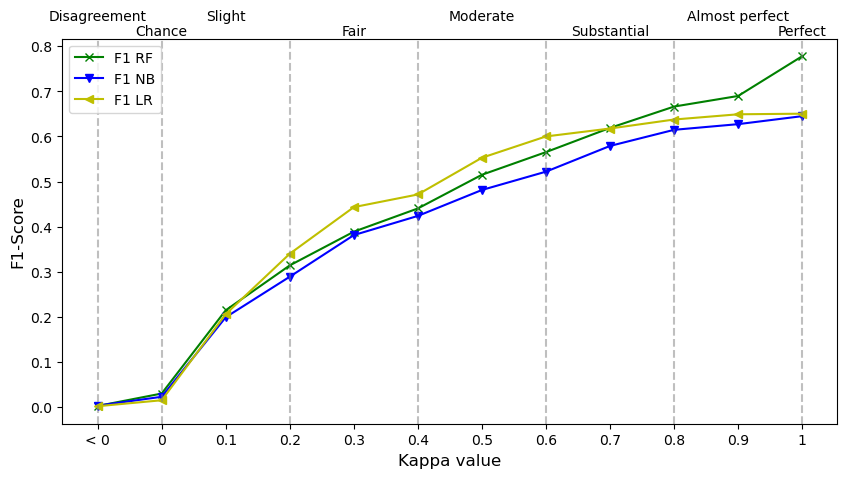

In [17]:
rf_f1 = rf_f1[::-1]
nb_f1 = nb_f1[::-1]
lr_f1 = lr_f1[::-1]

# Plot a simple line chart
plt.plot(agreements, rf_f1, 'g', label='F1 RF', marker='x')
plt.plot(agreements, nb_f1, 'b', label='F1 NB', marker='v')
plt.plot(agreements, lr_f1, 'y', label='F1 LR', marker='<')

plt.axvline(x=0, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=1, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=3, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=5, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=7, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=9, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=11, linestyle='dashed', color='gray', alpha=0.5)

y_pos = plt.ylim()[1]

plt.text(0, y_pos * 1.05, 'Disagreement', color='black', ha='center')
plt.text(1, y_pos * 1.01, 'Chance', color='black', ha='center')
plt.text(2, y_pos * 1.05, 'Slight', color='black', ha='center')
plt.text(4, y_pos * 1.01, 'Fair', color='black', ha='center')
plt.text(6, y_pos * 1.05, 'Moderate', color='black', ha='center')
plt.text(8, y_pos * 1.01, 'Substantial', color='black', ha='center')
plt.text(10, y_pos * 1.05, 'Almost perfect', color='black', ha='center')
plt.text(11, y_pos * 1.01, 'Perfect', color='black', ha='center')

plt.legend()
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams.update({'font.size': 10})

plt.xlabel('Kappa value', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)

plt.show()